## Synoptic Surface Map for Superstorm 1993
### This notebook's intent is to replicate Figure 5 from <a href="https://doi.org/10.1175/1520-0493(1997)125%3C3041:TMSCIP%3E2.0.CO;2">Dickinson et al. (1996)</a>:
![](../original/Fig5.png)

#### Currently, this notebook will show the last time (1800 UTC 12 March 1993, corresponding to Fig. 5d)
#### To do: Cloud cover and present weather symbols


## Data sources:
### GEMPAK surface data
### ERA-5 reanalysis data
#### Missing: Ship and buoy data; Mexican obs

In [1]:
from datetime import datetime,timedelta
import numpy as np
import matplotlib.pyplot as plt

import requests
import xarray as xr
from scipy.ndimage import gaussian_filter as gwfs
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeat

from metpy.calc import wind_components,potential_temperature,equivalent_potential_temperature
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.plots.wx_symbols import current_weather, sky_cover, wx_code_map

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS


# Load in a collection of functions that process GEMPAK weather conditions and cloud cover data.
import metargem

%matplotlib inline

In [5]:
# Set the date and time.

year = 1993
month = 3
day = 12
hour = 0

validTime = datetime(year, month, day, hour)

timeRange = []
for n in [0,1,2,3]:
    deltaTime = timedelta(hours=n*6)
    timeRange.append(validTime + deltaTime)

validTime = timeRange[-1]
timeStr = validTime.strftime("%Y-%m-%d %H UTC")
timeStr2 = validTime.strftime("%Y%m%d%H")

yyyy = validTime.strftime("%Y")
mm = validTime.strftime("%m")
dd = validTime.strftime("%d")
hh = validTime.strftime("%H")



## Note that the ERA-5 reanalysis datasets hosted at RDA require you to set up a user id and password at RDA, as well as register for ECMWF dataset access. For the purposes of this notebook below, the userid and password must be changed by you.

In [6]:
userid = 'ktyle@albany.edu'
pw = 'ss1993'

In [7]:
t2_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/199303/e5.oper.an.sfc.128_167_2t.ll025sc.1993030100_1993033123.nc'
td_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/199303/e5.oper.an.sfc.128_168_2d.ll025sc.1993030100_1993033123.nc'
sp_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.sfc/199303/e5.oper.an.sfc.128_134_sp.ll025sc.1993030100_1993033123.nc'

In [8]:
session = requests.Session()
session.auth = (userid, pw)
store = xr.backends.PydapDataStore.open(t2_url, session=session)
t2ds = xr.open_dataset(store)

In [9]:
session = requests.Session()
session.auth = (userid, pw)
store = xr.backends.PydapDataStore.open(sp_url, session=session)
spds = xr.open_dataset(store)

In [10]:
session = requests.Session()
session.auth = (userid, pw)
store = xr.backends.PydapDataStore.open(td_url, session=session)
tdds = xr.open_dataset(store)

In [11]:
t2ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 744)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1993-03-01 ... 1993-03-31T23:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 ...
    utc_date   (time) int32 ...
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.3
    CONVERSION_PLATFORM:             Linux r14i2n18 4.12.14-94.41-default #1 ...
    CONVERSION_DATE:                 Fri Jul  5 23:26:59 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Fri Jul  5 23:27:15 2019: ncks -4 --ppc ...
    NC

In [12]:
# Set the domain to gather data from and for defining the plot region.
latN = 40
latS = 20
lonW = -110 + 360
lonE = -78 + 360
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
lat_range=np.arange(latN,latS-.25,-.25)
lon_range=np.arange(lonW,lonE+0.25,0.25)

In [13]:
t2m = t2ds.sel(time=timeRange,latitude=lat_range,longitude=lon_range).VAR_2T

In [14]:
sp = spds.sel(time=timeRange,latitude=lat_range,longitude=lon_range).SP

In [15]:
td = tdds.sel(time=timeRange,latitude=lat_range,longitude=lon_range).VAR_2D

In [16]:
thte = equivalent_potential_temperature(sp,t2m,td)


### If our requested date precedes or follows the SAO to METAR surface file format transtion (xx-xx-1996), choose the appropriate catalog.

In [17]:
if (year >= 1996):
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metarArchive/ncdecoded/catalog.xml?dataset=metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr'
else:
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/saoArchive/ncdecoded/catalog.xml?dataset=saoArchive/ncdecoded/Archived_SAO_Station_Data_fc.cdmr'

catalog = TDSCatalog(metar_cat_url)

metar_dataset = catalog.datasets['Feature Collection']

In [18]:
ncss_url = metar_dataset.access_urls['NetcdfSubset']
# Import ncss client
ncss = NCSS(ncss_url)

What variables do we have available?

In [19]:
ncss.variables

{'ALTI',
 'CFRT',
 'COUN',
 'DRCT',
 'DWPK',
 'PMSL',
 'SPED',
 'SPRI',
 'STAT',
 'STD2',
 'STNM',
 'TMPK',
 'WWMO',
 '_isMissing'}

## Now, let's request all stations within a bounding box for a given time and create a surface station plot
 * Make new NCSS query
 * Request data closest to "now", or specify a specific YYMMDDHH yourself.


In [20]:
# Create an object to build our data query
query = ncss.query()


query.lonlat_box(north=latN, south=latS, east=lonE, west=lonW)
#query.time
query.time(timeRange[3])
#query.strides(time=6)
# Select the variables to query.  Note that the variable names depend on the source of the METAR data.
# The 'GEMPAK-like' 4-character names are from the UAlbany THREDDS.

#query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
#                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
#query.variables('TMPC', 'DWPC', 'PMSL',
#                'SKNT', 'DRCT','ALTI','WNUM','VSBY','CHC1', 'CHC2', 'CHC3','CTYH', 'CTYM', 'CTYL' )
query.variables('TMPK', 'PMSL','WWMO','CFRT','DWPK',
                'SPED', 'DRCT','ALTI' )
query.accept('csv')

var=DWPK&var=CFRT&var=TMPK&var=WWMO&var=ALTI&var=DRCT&var=SPED&var=PMSL&time=1993-03-12T18%3A00%3A00&west=250&east=282&south=20&north=40&accept=csv

## Create the map using cartopy and MetPy!

### Simple station plotting using plot methods

One way to create station plots with MetPy is to create an instance of `StationPlot` and call various plot methods, like `plot_parameter`, to plot arrays of data at locations relative to the center point.

In addition to plotting values, `StationPlot` has support for plotting text strings, symbols, and plotting values using custom formatting.

Plotting symbols involves mapping integer values to various custom font glyphs in our custom weather symbols font. MetPy provides mappings for converting WMO codes to their appropriate symbol. The `sky_cover` function below is one such mapping.

In [21]:
data = ncss.get_data(query)

/free4/ktyle/anaconda3/envs/op/lib/python3.7/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})


In [22]:
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = (data['TMPK'][:] * units ('degK')).to('degF')
dewp = (data['DWPK'][:] * units ('degK')).to('degF')
altm = (data['ALTI'][:] * units('inHg')).to('mbar')
slp = data['PMSL'][:]
#wthr = data['WNUM'][:].astype(int)
# replace missing wx codes or those >= 100 with 0
wnum = (np.nan_to_num(data['WWMO'][:],True).astype(int))
# Convert wind to components
u, v = wind_components((data['SPED']* units('m/s')).to('knots'), data['DRCT'] * units.degree)
#u, v = get_wind_components(sknt * units.knots, drct * units.degree)

# Need to handle missing (NaN) and convert to proper code
#cloud_cover = 8 * data['cloud_area_fraction']
#cloud_cover[np.isnan(cloud_cover)] = 10
#cloud_cover = cloud_cover.astype(np.int)
#chc1 = (np.nan_to_num(data['CHC1'],True).astype(int))
#chc2 = (np.nan_to_num(data['CHC2'],True).astype(int))
#chc3 = (np.nan_to_num(data['CHC3'],True).astype(int))
#cloud_cover = calc_clouds(chc1, chc2, chc3)

# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
#convert_wnum (wnum)

/free4/ktyle/anaconda3/envs/op/lib/python3.7/site-packages/metpy/calc/basic.py:799: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  'Ensure proper units are given.'.format(max_radians))


The next step deals with the removal of overlapping stations, using  `reduce_point_density`. This returns a mask we can apply to data to filter the points.

In [23]:
from metpy.calc import reduce_point_density

# Project points so that we're filtering based on the way the stations are laid out on the map
proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)

# Reduce point density so that there's only one point within a circle whose distance is specified in meters.
# This value will need to change depending on how large of an area you are plotting.
mask = reduce_point_density(xy, 60000)

Now we just plot with `arr[mask]` for every `arr` of data we use in plotting.

/free4/ktyle/anaconda3/envs/op/lib/python3.7/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/free4/ktyle/anaconda3/envs/op/lib/python3.7/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/free4/ktyle/anaconda3/envs/op/lib/python3.7/site-packages/metpy/plots/_mpl.py:331: MatplotlibDeprecationWarning: 
The is_math_text function was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  clean_line, ismath = self.is_math_text(line)


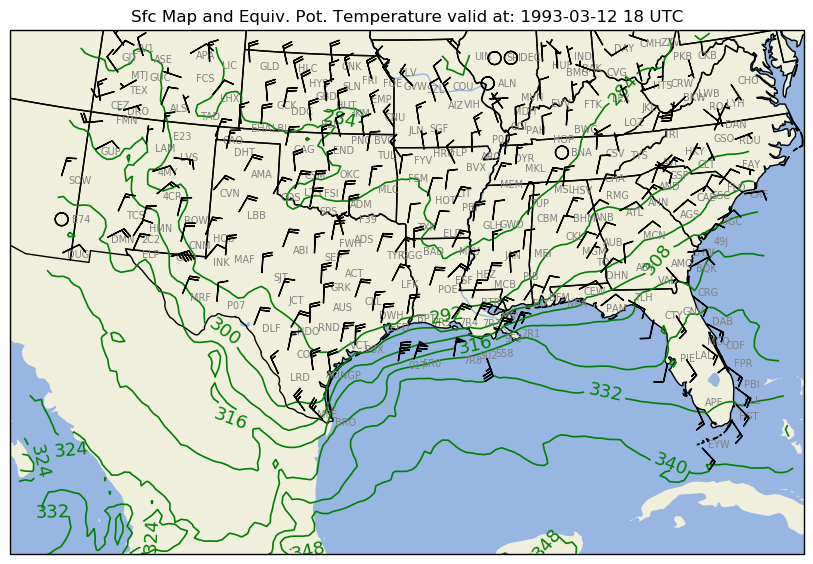

In [24]:
# Set up a plot with map features
dpi = 100
xpix = 1024
ypix = 768
# Figsize is always in inches.  Inches * dpi = pixels.  The line below will produce a 1024 x 768 png when saved to disk.
fig = plt.figure(figsize=(xpix/100,ypix/100), dpi=dpi)

proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
ax = fig.add_subplot(1, 1, 1, projection=proj)
land_mask = cfeat.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeat.COLORS['land'])
sea_mask = cfeat.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeat.COLORS['water'])
lake_mask = cfeat.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face',
                                        facecolor=cfeat.COLORS['water'])
ax.add_feature(land_mask)
ax.add_feature(sea_mask)
ax.add_feature(lake_mask)


# The features with names such as cfeat.LAND, cfeat.OCEAN, are lower-resolution (110m) shapefiles from the
# Naturalearth repository.  Higher resolution shapefiles (10m, 50m) can be used by using the cfeat.NaturalEarthFeature
# method as illustrated above for land and sea masks, and below for state/provinces.
#ax.add_feature (cfeat.LAND)
#ax.add_feature (cfeat.OCEAN)
#ax.add_feature(cfeat.COASTLINE)
#ax.add_feature (cfeat.BORDERS, linestyle=':')
#ax.add_feature (cfeat.LAKES, alpha = 0.5)
ax.add_feature(cfeat.RIVERS)

ax.set_extent ((lonW,lonE,latS,latN))

state_borders = cfeat.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                         scale='50m', facecolor='none')
ax.add_feature(state_borders, linestyle='solid', edgecolor='black')
#scale = '5m'
#ax.add_feature(USCOUNTIES.with_scale(scale))
#ax.add_feature(USCOUNTIES,edgecolor='grey')
#ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=7)
#stationplot.plot_parameter('NW', tair[mask], color='red', fontsize=10)
#stationplot.plot_parameter('SW', dewp[mask], color='darkgreen', fontsize=10)
#stationplot.plot_parameter('NE', slp[mask], color='purple')
# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
#stationplot.plot_parameter('NE', slp[mask], color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])

stationplot.plot_barb(u[mask], v[mask],zorder=100)
#stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)
#stationplot.plot_symbol('W', wnum[mask], current_weather,color='blue',fontsize=13)
stationplot.plot_text((2, 0),stid[mask], color='gray')
plt.title("Sfc Map and Equiv. Pot. Temperature valid at: "+ timeStr)


#Plot theta-e contours & labels
cint = np.arange(236,400,8)
CS = ax.contour(lon_range,lat_range,thte[3].m,cint,linewidths=1.2,colors='green',linestyles='solid',transform=ccrs.PlateCarree())
ax.clabel(CS, inline=1, fontsize=13,fmt='%.0f')

plt.savefig ('../figures/' + timeStr2 + '_sfmap.png',dpi=dpi)